## Рынок заведений общественного питания Москвы
*По условиям проекта заказчик решает открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Заказчика интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? Наша задача подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания Москвы* 

---

**В процессе исследования нам предстоит:** 
- [Исследовать соотношение видов объектов общественного питания по количеству. Построить график.](#step1)


- [Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график.](#step2)


- [Узнать, для какого вида объекта общественного питания характерно сетевое распространение?](#step3)


- [Узнать, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#step4)


- [Для каждого вида объекта общественного питания описать среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Нужно построить графики.](#step5)


- [Выделить в отдельный столбец информацию об улице из столбца  `address`](#step6) 


- [Построить график топ-10 улиц по количеству объектов общественного питания. Нужно будет воспользоваться внешней информацией и ответить на вопрос — в каких районах Москвы находятся эти улицы?](#step7)


- [Найти число улиц с одним объектом общественного питания. Нужно будет воспользоваться внешней информацией и ответить на вопрос — в каких районах Москвы находятся эти улицы?](#step8)


- [Посмотреть на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?](#step9)


- [Итоговые выводы](#step10)

### Для начала загрузим данные и нужные библиотеки, а затем сделаем предобработку. 

In [4]:
import datetime as dt 
from collections import Counter 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
pd.options.display.max_rows = 500
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.stats as stats 
import plotly.express as px
import itertools as it
from pymystem3 import Mystem
import io
import requests

rest = pd.read_csv('/datasets/rest_data.csv')

In [5]:
# посмотрим на названия колонок и попытаемся учесть проблемы, которые 
# могут быть с данными, при написании функции
print(rest.columns.to_list())

['id', 'object_name', 'chain', 'object_type', 'address', 'number']


In [6]:
def get_head_info_columns_duplicates_missing_values(df):
    print(rest.head(5))
    print('')
    print('---------------------------------------------------------------')
    print('')
    print(df.info())
    print(' ')
    print('---------------------------------------------------------------')
    print(' ')
    print('В датафрейме', df.loc[0, :].count(), 'колонок, их названия', 
         df.columns.to_list())
    print(' ')
    print('---------------------------------------------------------------')
    print(' ')
    print('В датафрейме содержится', df.duplicated().sum(), 'полных дубликатов')
    print(' ')
    print('---------------------------------------------------------------')
    print(' ')
    for column in df.columns:
        print('Пропусков в', column, ':', df[column].isna().sum())
    print(' ')
    print('---------------------------------------------------------------')
    print(' ')
    print(df['number'].describe())

In [7]:
get_head_info_columns_duplicates_missing_values(rest)

       id             object_name chain object_type  \
0  151635                 СМЕТАНА   нет        кафе   
1   77874                  Родник   нет        кафе   
2   24309         Кафе «Академия»   нет        кафе   
3   21894              ПИЦЦЕТОРИЯ    да        кафе   
4  119365  Кафе «Вишневая метель»   нет        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50  

---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_

In [8]:
# проверим наш датафрейм на неполные дубликаты убрав столбец 'id'
print(rest[rest[['object_name', 'chain', 'object_type', 'address', 'number']].\
           duplicated()].count())

id             82
object_name    82
chain          82
object_type    82
address        82
number         82
dtype: int64


#### На данном этапе видим в данных несколько проблем: 
- Есть неполные дубликаты
- Не все записи приведены к нижнему регистру

In [9]:
# видим, что у нас 82 неполных дубликата - уберем их 
rest = rest.drop_duplicates(subset=[
    'object_name', 'chain', 'object_type', 'address', 'number',
    ])

# проверим, отработала ли функция
print(rest[rest[['object_name', 'chain', 'object_type', 'address', 'number']].\
           duplicated()].count())

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


In [10]:
# приведем все записи к нижнему регистру
def lower_case(df):
    for column in ['object_name', 'chain', 'object_type', 'address']:
        df[column] = df[column].str.lower()
    return df
rest = lower_case(rest)
display(rest.head(3))
# все отработало, переходим к анализу 

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95


### Выводы: 
- на этапе предобработки в данных обнаружилось несколько проблем, во-первых, у нас есть неполные дубликаты
- во-вторых, не все записи приведены к нижнему регистру. 



**На данном этапе данные готовы для анализа**

### Посмотрим на соотношение видов объектов общественного питания по количеству<a id="step1"></a>  

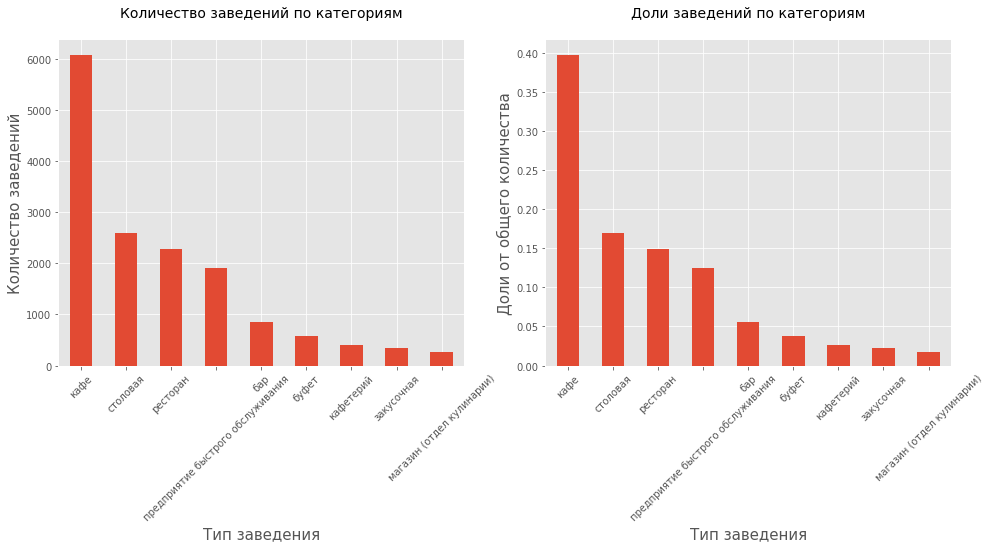

In [8]:
fig, ax = plt.subplots(1 ,2)

# построим график с количеством заведений
rest['object_type'].value_counts().plot(kind='bar',
                                    figsize=(16, 6), ax=ax[0])
ax[0].set_title('Количество заведений по категориям' + '\n', fontsize=14)
ax[0].set_xlabel('Тип заведения', fontsize=15)
ax[0].set_ylabel('Количество заведений', fontsize=15)
ax[0].tick_params(axis='x', labelrotation=45)

# построим второй график с долями 
rest['object_type'].value_counts(normalize=True).plot(kind='bar',
                                       figsize=(16, 6), ax=ax[1])
ax[1].set_title('Доли заведений по категориям' + '\n', fontsize=14)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_xlabel('Тип заведения', fontsize=15)
ax[1].set_ylabel('Доли от общего количества', fontsize=15)
plt.show()
fig.savefig('Количество и доли заведений')

###  Количество мест по типам заведений
Тип заведения| Количество мест | Доля от общего количества 
:---|:---|:---
кафе|                                 6099| 0.40
столовая|                            2587| 0.17
ресторан|                            2285| 0.15
предприятие быстрого обслуживания|   1923| 0.13
бар|                                   856| 0.06 
буфет|                                585| 0.04
кафетерий|                             398| 0.03
закусочная|                            360| 0.02
магазин (отдел кулинарии)|             273| 0.02

Видим, что **самые популярные места в Москве - кафе, на них приходится около 40 % всех заведений**, следом идут **столовые, рестораны, предприятия быстрого обслуживания (от 13 до 17 % от общего числа заведений)**. Совсем небольшую долю имеют бары, буфеты, кафетерии, закусочные, отделы кулинарии в магазинах (от 2 до 6 %). 

**Учитывая, что мы открываем кафе - конкуренция будет очень высока**

### Исследуем соотношение сетевых и несетевых заведений по количеству<a id="step2"></a>  

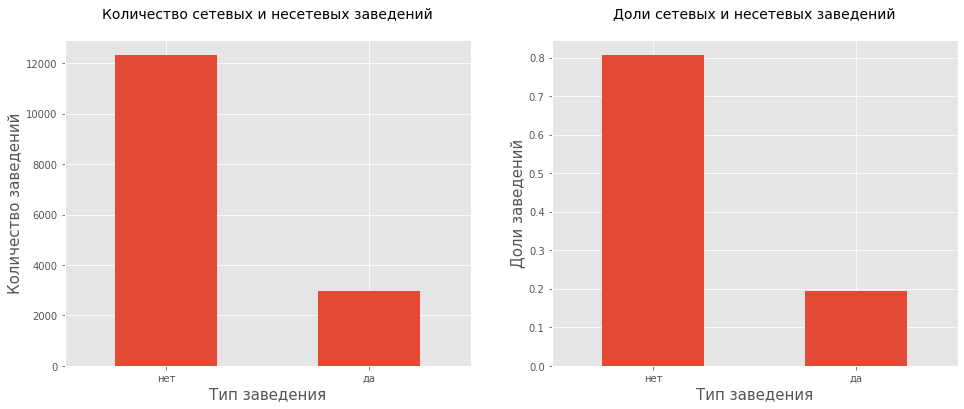

In [9]:
fig, ax = plt.subplots(1 ,2)
rest['chain'].value_counts().plot(kind='bar',
                                       figsize=(16,6), ax=ax[0])
ax[0].set_title('Количество сетевых и несетевых заведений' + '\n', fontsize=14)
ax[0].set_xlabel('Тип заведения', fontsize=15)
ax[0].set_ylabel('Количество заведений', fontsize=15)
ax[0].tick_params(axis='x', labelrotation=0)


rest['chain'].value_counts(normalize=True).plot(kind='bar',
                                       figsize=(16,6), ax=ax[1])
ax[1].set_title('Доли сетевых и несетевых заведений' + '\n', fontsize=14)
ax[1].set_xlabel('Тип заведения', fontsize=15)
ax[1].set_ylabel('Доли заведений', fontsize=15)
ax[1].tick_params(axis='x', labelrotation=0)

plt.show()
fig.savefig('Количество и доли сетевых и несетевых заведений')

**80 % заведений а нашем датасете не сетевые.**

### Для какого вида объекта общественного питания характерно сетевое распространение?<a id="step3"></a>

*Для того, чтобы понять, для какого типа заведений характерно сетевое расположение надо узнать долю сетевых заведений одного типа от всех заведений этого же типа.* 

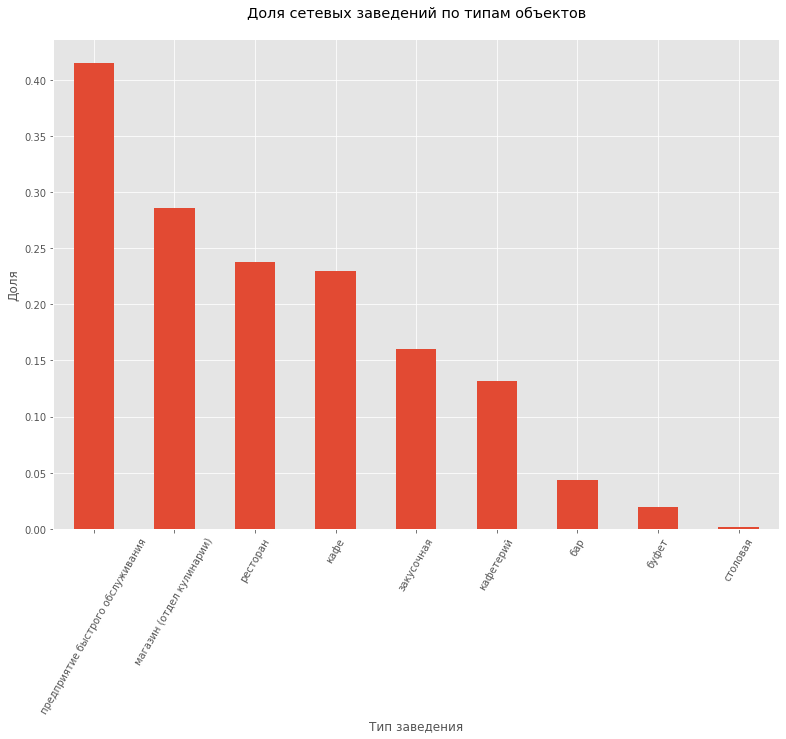

In [11]:
(rest.query('chain == "да"')['object_type'].\
 value_counts() / rest['object_type'].\
 value_counts()).sort_values(ascending=False).plot(kind='bar', figsize=(13,9))
plt.title('Доля сетевых заведений по типам объектов' + '\n')
plt.xlabel('Тип заведения')
plt.ylabel('Доля')
plt.xticks(rotation=60)
plt.show()

### Выводы: 
В целом мы получили довольно логичную картину - большинство сетевых заведений это предприятия быстрого обслуживания, а именно **более 40-ка процентов всех заведений, которые специализируются на фастфуде, сетевые.** 
С продуктовыми магазинами с отделами кулинарии тоже все кажется довольно очевидно. Немного сложнее обстоит дело с ресторанами. График показывает, что около 25 % ресторанов - сетевые. Интуитивно кажется, что многовато. Надо немного "пошерстить" контекст и случайно наткнуться на рекламу Burger King чтобы осознать, что данный фастфуд [позиционируют себе как ресторан](https://ru.wikipedia.org/wiki/Burger_King). Вероятно, что наши 25 % могли получиться отсюда. 

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?<a id="step4"></a>  

Важно обратить внимание, что у нас есть аномальные значения в столбце с количеством посадочных мест. Например, максимальное значение в столбце составляет 1700 мест. Возникает большой вопрос: а считать ли это значение выбросом. Вероятно, что нет, т.к. это вполне может оказаться банкетным залом. В Москве такие есть, например, [вот](https://eventcatalog.ru/area/moskva/na-1700-chelovek/).

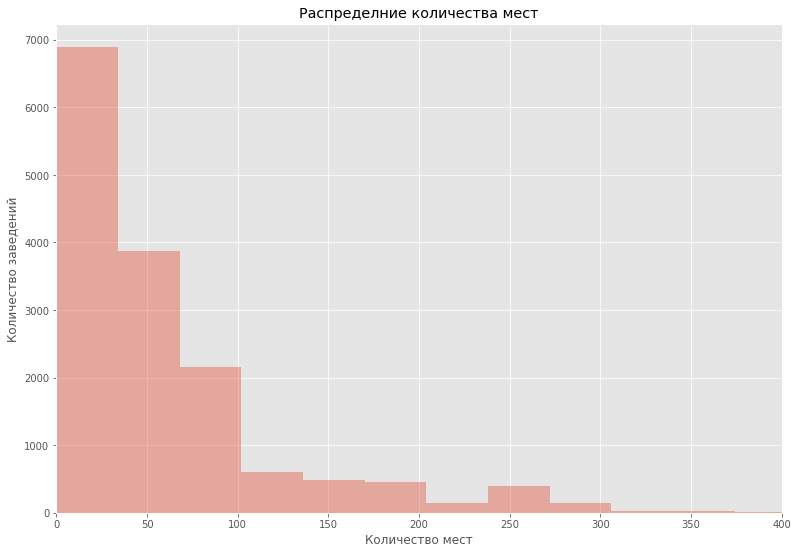

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

<Figure size 432x288 with 0 Axes>

In [12]:
# для начала посмотрим на расределение количества мест 
plt.figure(figsize=(13,9))
sns.distplot(rest['number'], kde=False)
plt.xlim(0, 400)
plt.title('Распределние количества мест')
plt.xlabel('Количество мест')
plt.ylabel('Количество заведений')
plt.show()
plt.savefig('Распределние количества мест')
display(rest['number'].describe())

In [13]:
chain_rest = rest.query('chain == "да"')
chain_rest['object_name'] = chain_rest['object_name'].str.lower()
# chain_rest['object_name'].unique()

In [14]:
# пробежимся по данным и посмотрим, какие еще у нас могут быть дубликаты
glossary = {'суши wok':'суши вок', 'пиццерия «академия»':'пиццерия академия', 'kfc':'кфс',
           'ресторан «якитория»':'якитория', 'кафе «subway»':'сабвей', 
            'ресторан «макдоналдс»':'макдоналдс','subway':'сабвей',
            'шоколадница кофе хаус':'шоколадница', 'бар- буфет ':'', 
            'кофе хаус. экспрессо и капучино бар':'кофе хаус', 
            'кофейня «шоколадница»':'шоколадница','кофе-хаус':'кофе хаус', 
            'кафе «шоколадница»':'шоколадница', 'старбакс starbucks':'старбакс',
            'starbucks':'старбакс', 'кафе «starbucks»':'старбакс', 
            'кофейня «старбакс»':'старбакс',
            'предприятие быстрого обслуживания «бургер кинг»':'бургер кинг', 
            'предприятие быстрого обслуживания «крошка картошка»':'крошка картошка',
            'предприятие быстрого обслуживания «макдоналдс»':'макдоналдс', 
            'магбургер азс №16':'магбургер азс', 'магбургер азс №17':'магбургер азс', 
            'кафе «prime» прайм стар':'кафе прайм', 'бургер кинг burger king':
            'бургер кинг', 'кафе «kfc»':'кфс', 'кафе «пицца хат»':' пицца хат', 
            'сабвей subway':'сабвей', 'ростикс kfc':'кфс', 'кофейня шоколадница':'шоколадница', 
            'закусочная kfc':'кфс', 'kfc волгоградский':'кфс', 'москва - макдоналдс': 
            'макдоналдс', 'кафе «старбакс»':'старбакс', 'кафе «кофейня старбакс»':'старбакс',
            'кафе макдоналдс':'макдоналдс', 'пбо «kfc покрышкина»':'кфс', 
            'кофейня «старбакс кофе»':'старбакс', 'предприятие быстрого обслуживания «kfc»':'кфс',
            'ресторан «бургер кинг»':'бургер кинг','кафе':'','ресторан':'', 'пиццерия':'',
            '-':'', '""':'', '«':'', '»':'', ' кфс':'кфс', ' тануки':'тануки',
            ' макдоналдс':'макдоналдс', ' бургер кинг':'бургер кинг'
            }
# напишем функцию, которая будет менять имена объектов
def clear_names(row):
    new_name = row['object_name']
    for bad_word in glossary:
        new_name = str(new_name).replace(bad_word, glossary[bad_word])
    return new_name
chain_rest['object_name'] = chain_rest.apply(clear_names, axis=1)
chain_rest['object_name'].nunique()

506

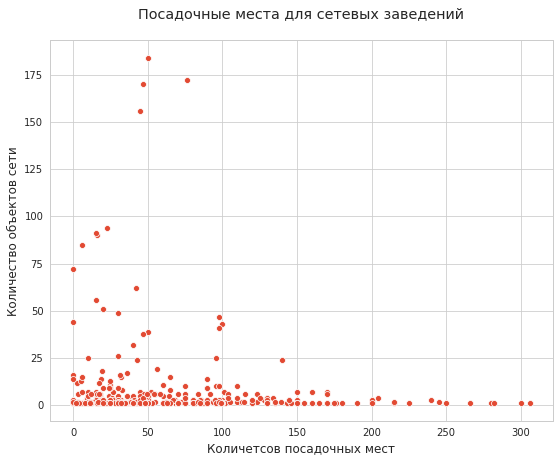

<Figure size 432x288 with 0 Axes>

In [15]:
# Построим график, где на оси y будет количество точек, которые открыты 
# у определенной сети, а по оси x количество посадочных мест.
sns.set_style("whitegrid")
chain_pivot = chain_rest.pivot_table(
    index='object_name', values=['id', 'number'], aggfunc={'id':'count', 'number':'median'})
plt.figure(figsize=(9,7))
sns.scatterplot(y=chain_pivot['id'], x=chain_pivot['number'])
plt.title('Посадочные места для сетевых заведений' + '\n')
plt.xlabel('Количетсов посадочных мест')
plt.ylabel('Количество объектов сети')
plt.show()
plt.savefig('Посадочные места для сетевых заведений')

Теперь ответим на вопрос, какое количество посадочных мест характерно для сетевых заведений. 
- Во-первых, представляется, что количество посадочных мест не зависит от того, сколько у сети точек. Мы видим четыре точки в правом верхнем углу - это сети, которые имеют наибольшее количество объектов в Москве (если, конечно, наша выборка репрезентативна) Эти точки - Шоколадница, КФС, Макдоналдс, Бургер Кинг). Видим, что они не отклоняются от общего тренда и медианное количество мест в них от 45 до 70. 
- Большинство сетевых заведений имеют до 100 посадочных мест, причем видно, что точки от нуля до ста распространились довольно равномерно.
- Лишь пять сетей имеют более 250 посадочных мест. 

### Опишем среднее количество посадочных мест для каждого вида объектов общественного питания. Ответим на вопрос, какой вид предоставляет в среднем самое большое количество посадочных мест.<a id="step5"></a>  

*Представляется, что у нас есть два наиболее очевидных способа подойти к решению этой задачи. Во-первых, сгруппируем данные по видам заведений, потом можно или посчитать медиану, или почистить столбец с количеством посадочных мест от аномальных значений и посчитать среднее. Выберем первый способ и посчитаем медиану.*

In [16]:
display(rest.pivot_table(index='object_type', values='number', 
                aggfunc='median'))
display(rest[rest['object_type'] =='магазин (отдел кулинарии)']['number'].tail(5))
# очевидно, что у нас есть значения, которые равны нулю.
# думаю, что это неправильно загруженные данные, особенно в случае с закусочными
# возможно, что у некоторых отделов кулинарии действительно нет посадочных мест, но нас такие заведения 
# не интересуют, потому что в нашем заведение будут посадочные места
number_of_seat_grouped_by_kind = rest.query('number != 0')
number_of_seat_grouped_by_kind = number_of_seat_grouped_by_kind.\
pivot_table(index='object_type', values='number', 
                aggfunc='median')

,number
object_type,
бар,35
буфет,32
закусочная,0
кафе,30
кафетерий,6
магазин (отдел кулинарии),0
предприятие быстрого обслуживания,6
ресторан,80
столовая,103


15332    0
15333    0
15334    0
15335    0
15338    0
Name: number, dtype: int64

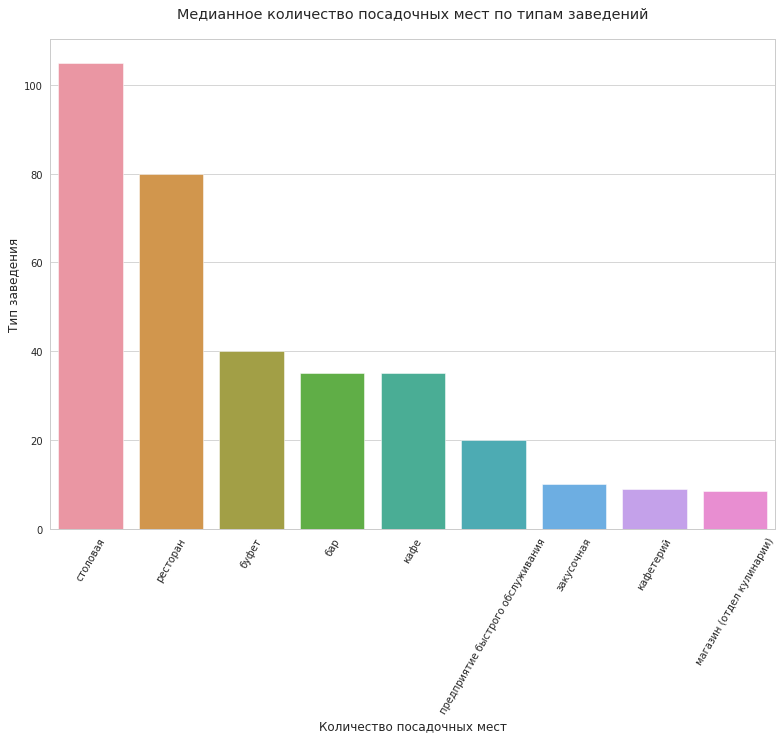

In [17]:
number_of_seat_grouped_by_kind = number_of_seat_grouped_by_kind.\
sort_values(by='number', ascending=False)
plt.figure(figsize=(13,9))
sns.barplot(number_of_seat_grouped_by_kind.index, 
           number_of_seat_grouped_by_kind['number'])
plt.xticks(rotation=60)
plt.title('Медианное количество посадочных мест по типам заведений' + '\n')
plt.xlabel('Количество посадочных мест')
plt.ylabel('Тип заведения')
plt.savefig('Медианное количество посадочных мест по типам заведений')
plt.show()

### Выводы: 
- **столовая и ресторан предоставляют наибольшее количество мест.** Надо сказать что разрыв с другими типами заведений очень большой. У столовой среднее количество мест более 100, у ресторана - 80, а у буфета, который на третьем месте - всего 40
- у семи из девяти типов заведений среднее количество посадочных мест не более 40
- **меньше всего посадочных мест у закусочных, кафетериев и отделов кулинарии в магазинах**

### Выделим в отдельный столбец информацию об улице<a id=step6></a>

In [18]:
display(rest['address'].head(5))
# посмотрим, какие географические наименования у нас встречаются наиболее часто
m = Mystem()
typical_locations = rest['address'].apply(m.lemmatize)
word_counts = Counter(it.chain(*typical_locations))

# выведем список из 200-т самых встречающихся слов
display(word_counts.most_common(200))

# составим список наиболее встречающихся наименования эквивалентных улице
location_names = ['улица', 'проспект', 'шоссе', 'проезд', 'бульвар', 'переулок',
                 'набережная', 'площадь', 'владение', 'аллея']

0           город москва, улица егора абакумова, дом 9
1    город москва, улица талалихина, дом 2/1, корпус 1
2            город москва, абельмановская улица, дом 6
3              город москва, абрамцевская улица, дом 1
4    город москва, абрамцевская улица, дом 9, корпус 1
Name: address, dtype: object

[(' ', 57229),
 (', ', 38188),
 ('город', 15616),
 ('\n', 15284),
 ('москва', 15221),
 ('дом', 14765),
 ('улица', 9036),
 ('1', 4612),
 ('строение', 4119),
 ('корпус', 2759),
 ('2', 2498),
 ('проспект', 1474),
 ('шоссе', 1317),
 ('3', 1246),
 ('-', 1243),
 ('/', 1188),
 ('4', 954),
 ('5', 847),
 ('проезд', 790),
 ('бульвар', 746),
 ('переулок', 725),
 ('6', 682),
 ('большой', 653),
 ('7', 629),
 ('8', 551),
 ('10', 522),
 ('9', 497),
 ('12', 490),
 ('я', 465),
 ('поселение', 417),
 ('й', 408),
 ('11', 404),
 ('набережная', 389),
 ('площадь', 384),
 ('15', 370),
 ('13', 365),
 ('14', 342),
 ('16', 338),
 ('22', 305),
 ('владение', 303),
 ('20', 294),
 ('18', 291),
 ('вал', 288),
 ('17', 286),
 ('26', 284),
 ('21', 282),
 ('ленинградский', 272),
 ('19', 269),
 ('ленинский', 264),
 ('зеленоград', 232),
 ('24', 218),
 ('23', 209),
 ('27', 208),
 ('мир', 204),
 ('25', 194),
 ('профсоюзный', 182),
 ('пресненский', 178),
 ('московский', 172),
 ('арбат', 169),
 ('32', 169),
 ('29', 167),
 ('ва

In [19]:
# видим, что чаще всего улица располагается на втором месте в адресе - 
# напишем функцию, чтобы доставать из адресов улицы 
def get_street(address):
    for position in [0,1,2]:
        for address_part in address.split(',')[position].split( ):
            if address_part in location_names:
                street = address.split(', ')[position]
                return street
rest['street'] = rest['address'].apply(get_street) 

In [20]:
# когда мы лемматизировали и смотрели на наиболее частные слова, мы решили не брать географические 
# наименования 'поселок', 'деревня', 'поле' и т.д. т.к. они скорее всего находятся за пределами Москвы, 
# а соответственно нас не интересуют. Посмотрим, сколько их было 
rest['street'].isna().sum()

495

### Построим график топ-10 улиц по количеству заведений<a id='step7'></a>

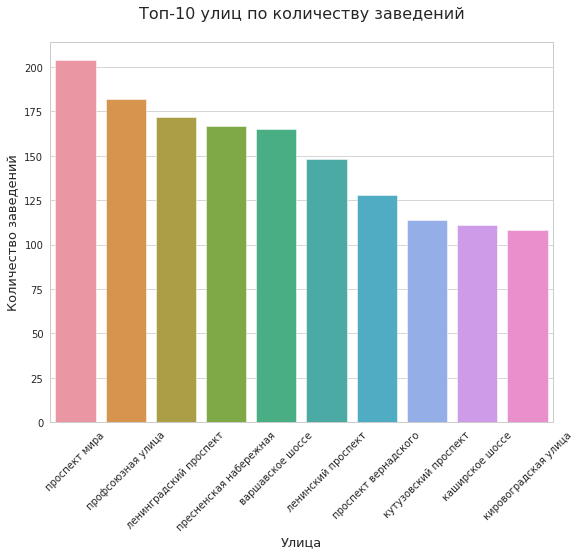

In [21]:
# сгруппируем данные по улице и количеству заведений на улице
streets_by_number_of_places = rest.pivot_table(
index='street', values='id', aggfunc='count')

# выведем топ-10 улиц по количеству заведений
top_10_streets_by_place = streets_by_number_of_places.\
sort_values(by='id', ascending=False).head(10)

# построим график
plt.figure(figsize=(9,7))
sns.barplot(x=top_10_streets_by_place.index,
           y=top_10_streets_by_place['id'])
plt.title('Топ-10 улиц по количеству заведений'+'\n', fontsize=16)
plt.xlabel('Улица', fontsize=13)
plt.ylabel('Количество заведений', fontsize=13)
plt.xticks(rotation=45)
plt.show()

In [22]:
# посмотрим, в каких районах эти улицы
# подключим внешний источник 
url = 'https://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv' 
s = requests.get(url).content
street = pd.read_csv(io.StringIO(s.decode('utf-8')))
street.info()
for column in ['streetname', 'area']:
    street[column] = street[column].str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
streetname    4398 non-null object
areaid        4398 non-null int64
okrug         4398 non-null object
area          4398 non-null object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB


In [23]:
top_10_streets_index = top_10_streets_by_place.index.to_list()

In [24]:
top_10_streets = top_10_streets_by_place.index.to_list()
for i in top_10_streets:
    print(i, 'входит в')
    print(street.query('streetname == @i')['area'])
    print(' ')

проспект мира входит в
2293    алексеевский район
2390     ярославский район
2531    район марьина роща
2578    останкинский район
2644       район ростокино
2712        район свиблово
4334       мещанский район
Name: area, dtype: object
 
профсоюзная улица входит в
3845    академический район
3867        район черемушки
3916          район ясенево
3948         район коньково
3996      обручевский район
4024      район теплый стан
Name: area, dtype: object
 
ленинградский проспект входит в
1857       район аэропорт
1896        район беговой
1992    хорошевский район
2150          район сокол
Name: area, dtype: object
 
пресненская набережная входит в
72    пресненский район
Name: area, dtype: object
 
варшавское шоссе входит в
3105    район чертаново центральное
3117       район чертаново северное
3125          район чертаново южное
3241                  донской район
3305       район нагатино-садовники
3349                 нагорный район
3999          район северное бутово
4065       

In [25]:
top_areas = street.query('streetname == @top_10_streets')['area']
top_areas.value_counts()

район гагаринский                  2
район нагатино-садовники           2
район чертаново центральное        2
район теплый стан                  2
обручевский район                  2
район проспект вернадского         2
район чертаново южное              2
донской район                      2
район тропарево-никулино           2
район чертаново северное           2
ломоносовский район                2
район черемушки                    1
пресненский район                  1
район дорогомилово                 1
мещанский район                    1
хорошевский район                  1
район коньково                     1
район якиманка                     1
район марьина роща                 1
район ростокино                    1
район беговой                      1
район орехово-борисово северное    1
район аэропорт                     1
район сокол                        1
район фили-давыдково               1
нагорный район                     1
ярославский район                  1
р

### Выводы: 
Представляется, что вывод, который нам нужно сделать в данном пункте заключается в том, что **улицы, на которых больше всего объектов, очень длинные.** Мы видели, что одна улица может входить в 6-7 районов. Например, проспект Мира - на котором находится более 200-т заведений тянется на 7 районов. Тот же самый тренд заметен и на других улицах.  

### Надем число улиц с одним объектом общественного питания и ответим на вопрос, в каких районах они находятся. Построим график топ-10 районов. <a id='step8'></a>

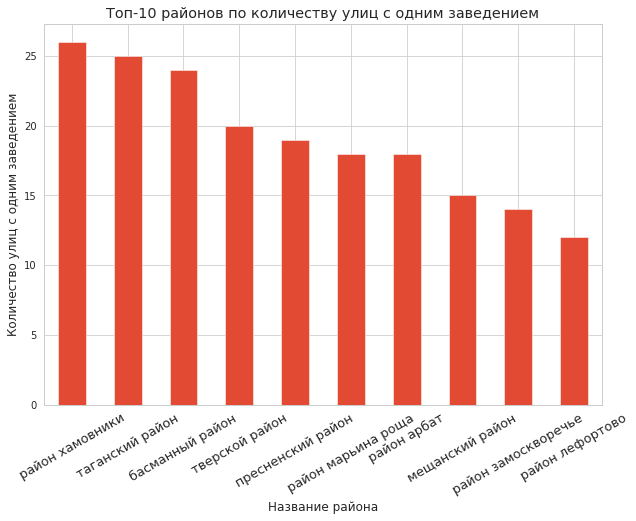

In [26]:
# выделим улицы с одним заведением 
streets_by_number_of_places
streets_with_one_place = streets_by_number_of_places[
    streets_by_number_of_places['id'] == 1
]

# выделим только название улиц 
streets_names_with_one_place = streets_with_one_place.index.to_list()

# посмотрим в каких они районах и визуализируем топ-10 районов
areas_for_single_places_streets = street.query(
'streetname == @streets_names_with_one_place')['area']
plt.figure(figsize=(10,7))
areas_for_single_places_streets.value_counts().head(10).plot(kind='bar')
plt.title('Топ-10 районов по количеству улиц с одним заведением')
plt.xlabel('Название района')
plt.ylabel('Количество улиц с одним заведением')
plt.xticks(rotation=30, fontsize=13)
plt.show()

### Выводы: 
- в Хамовниках, Таганском и Басманном районах более 20-ти улиц, на которых по одному заведению. 

### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания и попробуем выделить закономерности. <a id='step9'></a>

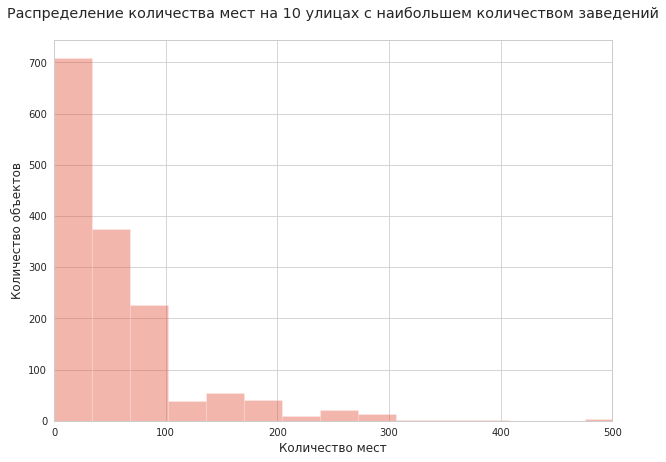

In [29]:
top_10_streets_df = rest.query('street in @top_10_streets_by_place.index')
plt.figure(figsize=(10,7))
sns.distplot(top_10_streets_df['number'], kde=False)
plt.xlim(0,500)
plt.title('Распределение количества мест на 10 улицах с наибольшем количеством заведений'+'\n')
plt.xlabel('Количество мест')
plt.ylabel('Количество объектов')
plt.show()

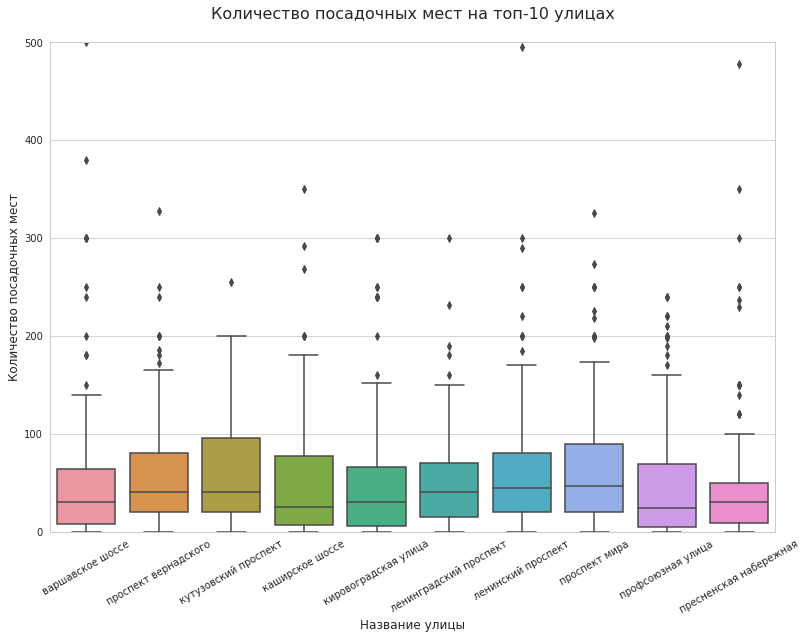

In [30]:
# пока не видим ничего аномального, распределение похоже на то распределение признака number по всем точкам
# попробуем построить boxplots 
plt.figure(figsize=(13,9))
sns.boxplot(x=top_10_streets_df['street'], y=top_10_streets_df['number'])
plt.title('Количество посадочных мест на топ-10 улицах'+'\n', fontsize=16)
plt.xlabel('Название улицы')
plt.ylabel('Количество посадочных мест')
plt.ylim(0,500)
plt.xticks(rotation=30)
plt.show()

In [31]:
pd.options.display.float_format = '{:,.2f}'.format
for i in [75, 90, 95]:
    print(i,'-й перцентиль количества мест по 10 главным улицам', 
          np.percentile(top_10_streets_df['number'], int(i)))
    print(i,'-й перцентиль количества мест по всем улицам',
            np.percentile(rest['number'], i))

75 -й перцентиль количества мест по 10 главным улицам 75.0
75 -й перцентиль количества мест по всем улицам 80.0
90 -й перцентиль количества мест по 10 главным улицам 138.4000000000001
90 -й перцентиль количества мест по всем улицам 150.0
95 -й перцентиль количества мест по 10 главным улицам 200.0
95 -й перцентиль количества мест по всем улицам 215.0


### Выводы: 
- на боксплотах мы видим, что зачастую **50 % мест**, которые располагаются на самых популярных улицах, **имеют не более 50 мест**
- не более 5% мест на самых популярных по количеству объектов улицах имеют более 200-т мест

###  Итоговые выводы:<a id='step10'></a> 

###### Исследовательский анализ 
- Cамые популярные места в Москве - кафе, на них приходится около 40 % всех заведений, следом идут столовые, рестораны, предприятия быстрого обслуживания (от 13 до 17 % от общего числа заведений). Совсем небольшую долю имеют бары, буфеты, кафетерии, закусочные, отделы кулинарии в магазинах (от 2 до 6 %). Учитывая, что мы открываем кафе, то нам придется конкурировать с 40% объектами общепита.
- 80 % мест, представленных в нашем датасете не сетевые. Надо отметить, что сетевое распространение не характерно для кафе - лишь 1/5 всех кафе сетевые
- Большинство сетевых заведений имеют до 100 посадочных мест
- Количество посадочных мест не зависит от того, сколько у сети точек
- Столовая и ресторан предоставляют наибольшее количество мест. Надо сказать что разрыв с другими типами заведений очень большой. У столовой среднее количество мест более 100, у ресторана - 80, а у буфета, который на третьем месте - всего 40
- У 50 % кафе не более 40 посадочных мест
- Меньше всего посадочных мест у закусочных, кафетериев и отделов кулинарии в магазинах


###### Географические выводы: 
**Больше всего заведений (от 110 до 200) располагаются на:**
- Проспекте Мира,
- Профсоюзной улице,
- Ленинградском проспекте,
- Пресненской набережной,
- Варшавском шоссе,
- Ленинском проспекте,
- Проспекте Вернадского,
- Кутузовском проспекте,
- Каширском шоссе,
- Кировоградской улице


**Улицы, на которых больше всего объектов, очень длинные. Одна улица может входить в 6-7 районов. Например, проспект Мира - на котором находится более 200-т заведений, тянется на 7 районов. Тот же самый тренд заметен и на других улицах.**

- В Хамовниках, Таганском и Басманном районах более 20-ти улиц, на которых по одному заведению.

### Рекомендации
- **Открывая не сетевое кафе, мы пытаемся отвоевать аудиторию на самой конкурентной
части рынка. Мы сделали количественное исследование рынка и по его итогам мы
можем сказать, что небольшое - это кафе на 40 посадочных мест.**

- Для того, чтобы понять, как целевая аудитория примет идею с роботами, надо провести не
только количественное исследование рынка, но и качественно UX-исследование, чтобы
понять, а готова ли наша целевая аудитория.

- Для того, чтобы решить, в какой географической локации лучше открывать кафе, стоит
проанализировать еще несколько показателей, а именно, попытаться узнать средний “период
жизни” кафе на одной из “топ” улиц, а также сузить наш выбор до нескольких локаций и
рассчитать для них проходимость.